##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 积分梯度

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/interpretability/integrated_gradients"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在  TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
  <td><a href="https://tfhub.dev/google/imagenet/inception_v1/classification/4"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型</a></td>
</table>

本教程演示如何实现**积分梯度 (IG)**，这是 [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365) 一文中介绍的一种[可解释人工智能](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence)技术。IG 旨在解释模型特征预测之间的关系。它有许多用例，包括了解特征重要性、识别数据倾斜以及调试模型性能。

由于广泛适用于任何可微分模型（例如图像、文本、结构化数据）、易于实现、拥有理论依据并且相对于允许其扩展到大型网络和特征空间（例如图像）的替代方法拥有更高的计算效率，IG 成为一种流行的可解释性技术。

在本教程中，您将逐步完成 IG 的实现，以了解图像分类器的像素特征重要性。例如，考虑这张消防船喷水的[图像](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg)。您可以将此图像分类为消防船，并突出显示构成船和水炮的像素，这些像素对您的决策十分重要。在本教程的后面部分，您的模型也会将此图像分类为消防船；不过，在解释其决策时，它是否会将这些相同的像素突出显示为重要像素？

在下面标题为“IG Attribution Mask”和“Original + IG Mask Overlay”的图像中，您可以看到模型（以紫色）突出显示了构成船上水炮和水柱的像素，与船本身相比，它们对决策的重要性更大。您的模型将如何泛化到新的消防船？没有水柱的消防船怎么办？请继续阅读，详细了解 IG 工作原理以及如何将 IG 应用于模型以更好地理解其预测与底层特征之间的关系。

![Output Image 1](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/interpretability/images/IG_fireboat.png?raw=1)

## 设置

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

### 从 TF-Hub 下载预训练的图像分类器

IG 可应用于任何可微分模型。本着原始论文的精神，您将使用相同模型的预训练版本 Inception V1，可以从 [TensorFlow Hub](https://tfhub.dev/google/imagenet/inception_v1/classification/4) 下载该模型。

In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


在模块页面上，您需要牢记有关 Inception V1 的以下几点：

**输入**：模型的预期输入形状为 `(None, 224, 244, 3,)`。这是 dtype float32 和形状 `(batch_size, height, width, RGB channels)` 的密集 4D 张量，其元素是标准化为 [0, 1] 范围的像素 RGB 颜色值。第一个元素为 `None`，表示模型可以采用任何整数批次大小。

**输出**：logits 的 `tf.Tensor`，形状为 `(batch_size, 1001)`。每行表示来自 ImageNet 的 1,001 个类中一个类的模型预测得分。对于模型的顶级预测类索引，您可以使用 `tf.argmax(predictions, axis=-1)`。此外，您还可以使用 `tf.nn.softmax(predictions, axis=-1)` 将模型的 logits 输出转换为跨所有类的预测概率，以量化模型的不确定性以及探索相似预测类来进行调试。

In [ ]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [ ]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

### 使用 `tf.image` 加载和预处理图像

您将使用来自 [Wikimedia Commons](https://commons.wikimedia.org/wiki/Main_Page) 的两个图像来说明 IG：一艘[消防船](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg)和一只[大熊猫](https://commons.wikimedia.org/wiki/File:Giant_Panda_2.JPG)。

In [ ]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [ ]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

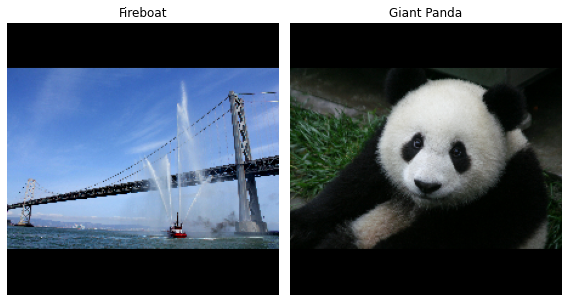

In [ ]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

### 对图像分类

首先，对这些图像分类并显示最确信的 3 个预测。下面是一个用于检索前 k 个预测标签和概率的效用函数。

In [ ]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

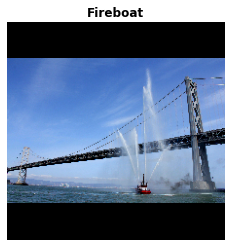

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


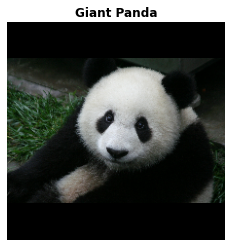

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [ ]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

## 计算积分梯度

您的模型 Inception V1 是一个学习函数，它描述了输入特征空间、图像像素值与 ImageNet 类概率值（介于 0 和 1 之间）定义的输出空间之间的映射。神经网络的早期可解释性方法使用梯度来指定特征重要性得分，梯度可以告诉您在模型预测函数的给定点处，哪些像素的局部相对于模型预测最陡。但是，梯度仅描述模型的预测函数中相对于像素值的*局部*变化，而不能完全描述整个模型的预测函数。当您的模型完全“学习”单个像素的范围与正确的 ImageNet 类之间的关系后，此像素的梯度将*饱和*，这意味着它变得越来越小，甚至减小为零。考虑下面的简单模型函数：

In [ ]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

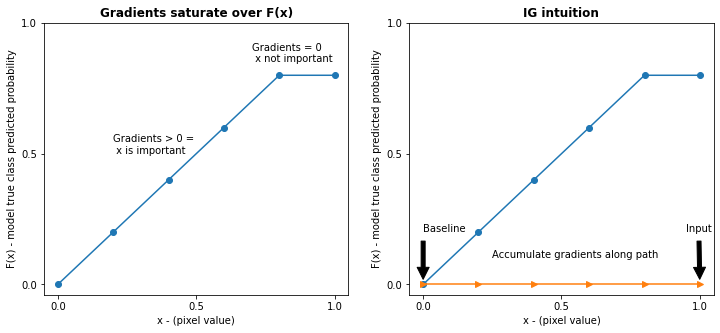

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

- **左侧**：像素 `x` 的模型梯度在 0.0 到 0.8 之间为正，但在 0.8 到 1.0 之间变为 0.0。像素 `x` 显然对将模型推向真实类的 80% 预测概率具有重大影响。<em data-md-type="raw_html">像素 `x` 的重要性小或不连续是否合理？</em>

- **右侧**：IG 背后的直觉是累积像素 `x` 的局部梯度，并将其重要性归因于它对模型的整体输出类概率增加或减少的得分。您可以用 3 个部分来分解和计算 IG：

    1. 在特征空间中沿直线在 0（基线或起点）与 1（输入像素的值）之间插入小步
    2. 计算模型预测之间的每个步骤相对于每个步骤的梯度
    3. 通过累积（累积平均值）这些局部梯度来近似估算基线与输入之间的积分。

为了增强这种直觉，您会通过将 IG 应用于下面的示例“消防船”图像来逐步完成这 3 个部分。 

### 建立基线

基线是用作计算特征重要性的起点的输入图像。直觉上，您可以认为基线的解释性作用代表了每个像素的缺失对“消防船”预测的影响，这与输入图像中存在的每个像素对“消防船”预测的影响形成对比。因此，基线的选择在解释和可视化像素特征重要性方面起到核心作用。有关基线选择的其他讨论，请参见本教程底部“后续步骤”部分中的资源。在这里，您将使用像素值均为零的黑色图像。

您可以尝试的其他选择包括全白图像或随机图像，可以使用 `tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)` 创建随机图像。

In [ ]:
baseline = tf.zeros(shape=(224,224,3))

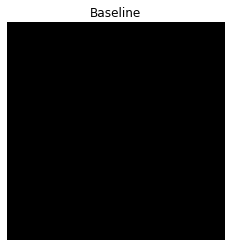

In [ ]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### 将公式解包为代码

积分梯度的公式如下：

$IntegratedGradients_{i}(x) ::= (x_{i} - x'*{i})\times\int*{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

其中：

$_{i}$ = 特性<br> $x$ = 输入<br> $x'$ = 基线<br> $\alpha$ = 扰动特征使用的插值常数

实际上，计算定积分并不总是在数值上可行，而且会消耗较多计算资源，因此您可以计算以下数值近似值：

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times\sum*{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

其中：

$*{i}$ = 特征（单个像素） $x$ = 输入（图像张量） $x'$ = 基线（图像张量） $k$ = 缩放的特征微扰常数 $m$ = 积分的黎曼和近似步数 $(x*{i}-x'_{i})$ = 相对于基线的差异项。这对于缩放积分梯度并以原始图像的形式保存它们十分必要。从基线图像到输入的路径位于像素空间中。由于使用 IG 时您沿直线积分（线性变换），这最终大致相当于插值图像函数的导数相对于具有足够步数的 $\alpha$ 的积分项。此积分会将每个像素的梯度与像素沿路径的变化之积相加。将此积分作为从一个图像到另一个图像的统一步骤来实现更简单，可以替代 $x = (x0 + a(x1-x0))$。因此，变量的变化为 $dx = (x1-x0)da$。$(x1-x0)$ 项是常数，不计入积分。

### 插值图像

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times\sum*{k=1}^{m}\frac{\partial F(\overbrace{x' + \frac{k}{m}\times(x - x')}^\text{interpolate m images at k intervals})}{\partial x_{i}} \times \frac{1}{m}$

首先，您将在基线与原始图像之间生成[线性插值](https://en.wikipedia.org/wiki/Linear_interpolation)。您可以将插值图像视为特征空间中基线与输入之间的小步，在原始等式中用 $\alpha$ 表示。

In [ ]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [ ]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

我们使用上面的函数沿线性路径在黑色基线图像与示例“消防船”图像之间的 alpha 间隔处生成插值图像。

In [ ]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

我们来可视化插值图象。注：关于 $\alpha$ 常数的另一种思考方式为，它会不断增加每个插值图像的强度。

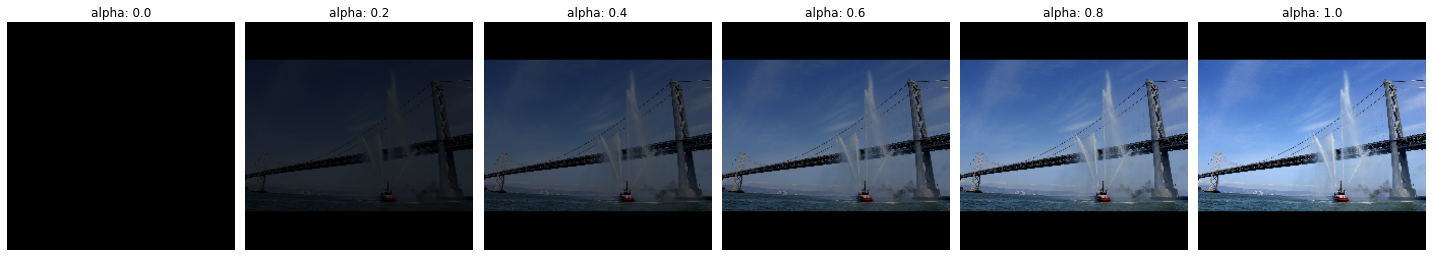

In [ ]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

### 计算梯度

现在，我们看一下如何计算梯度，以衡量特征的变化与模型预测的变化之间的关系。对于图像，梯度会告诉我们哪些像素对模型预测的类概率影响最大。

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times\sum*{k=1}^{m}\frac{\overbrace{\partial F(\text{interpolated images})}^\text{compute gradients}}{\partial x_{i}} \times \frac{1}{m}$

其中： $F()$ = 模型的预测函数 $\frac{\partial{F}}{\partial{x_i}}$ = 模型 F 的预测函数相对于每个特征 $x_i$ 的梯度（偏导数 $\partial$ 的向量）

TensorFlow 利用 [`tf.GradientTape`](https://tensorflow.google.cn/api_docs/python/tf/GradientTape) 让您轻松计算梯度。

In [ ]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

我们计算每个图像沿插值路径相对于正确输出的梯度。回想一下，模型返回了一个 `(1, 1001)` 形状的 `Tensor`，您将其 logits 转换为每个类的预测概率。您需要将正确的 ImageNet 目标类索引传递给图像的 `compute_gradients` 函数。

In [ ]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555)

注意 `(n_interpolated_images, img_height, img_width, RGB)` 的输出形状，它为我们提供了每个图像的每个像素沿插值路径的梯度。您可以利用这些梯度来衡量模型对特征空间中每个小步的预测的变化。

In [ ]:
print(path_gradients.shape)

(51, 224, 224, 3)


**可视化梯度饱和**

回想一下，您在上面计算出的梯度描述了模型对“消防船”的预测概率的*局部*变化，并且可能会*饱和*。

可以使用您在下面的 2 个图中计算出的梯度将这些概念可视化。

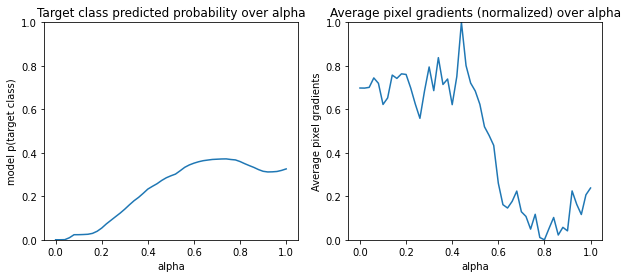

In [ ]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

- **左侧**：这张图显示了模型对“消防船”类置信度在各个 alpha 中如何变化。请注意，在将“消防船”的最终预测概率固定在 40% 之前，梯度（即直线的斜率）如何在 0.6 和 1.0 之间很大程度上变平或饱和。

- **右侧**：右图更直接地显示了 alpha 上的平均梯度幅值。请注意这些值如何急剧接近甚至短暂降至零以下。实际上，您的模型会在 alpha 值较小时从梯度中“学到”最多。直觉上，您可以认为这是因为您的模型已经学习了这些像素（例如水炮），可做出正确的预测并将这些像素梯度发送到零，但模型仍然存在一些不确定性，会在 alpha 值接近原始输入图像时关注虚假的桥或水柱像素。

为确保将这些重要的水炮像素反映为对“消防船”预测重要，您将在下面继续学习如何累积这些梯度，以准确估算每个像素如何影响您的“消防船”预测概率。


### 累积梯度（积分逼近）

您可以采用多种不同的方法来计算 IG 的积分数值逼近，但要在准确率和跨不同函数的收敛之间进行各种权衡。一类流行的方法称为[黎曼和](https://en.wikipedia.org/wiki/Riemann_sum)。在这种方法中，您将使用梯形法则（在本教程的末尾，您可以找到附加代码来探索不同的逼近方法）。

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times \overbrace{\sum*{k=1}^{m}}^\text{Sum m local gradients} \text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{Divide by m steps}$

从等式中，您可以看到您正在对 `m` 个梯度求和并除以 `m` 个步骤。您可以将第 3 部分的这两个运算一起实现为 <em data-md-type="raw_html">`m` 个插值预测和输入图像的局部梯度平均值</em>。

In [ ]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

`integral_approximation` 函数采用目标类的预测概率相对于基线与原始图像之间的插值图像的梯度。

In [ ]:
ig = integral_approximation(
    gradients=path_gradients)

您可以确认对 `m` 个插值图像的梯度求平均值后会返回一个与原始“大熊猫”图像具有相同形状的积分梯度张量。

In [ ]:
print(ig.shape)

(224, 224, 3)


### 将它们结合起来

现在，您将把前面的 3 个常规部分组合到 `IntegratedGradients` 函数中，并利用 [@tf.function](https://tensorflow.google.cn/guide/function) 装饰器将其编译为一个高性能的可调用 Tensorflow 计算图。这可通过以下 5 个更小的步骤实现：


$IntegratedGrads^{approx}*{i}(x)::=\overbrace{(x*{i}-x'*{i})}^\text{5.}\times \overbrace{\sum*{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. 生成 alphas $\alpha$

2. 生成插值图像 = $(x' + \frac{k}{m}\times(x - x'))$

3. 计算模型 $F$ 输出预测之间相对于输入特征的梯度 = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. 求积分逼近的平均值 = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. 相对于原始图像缩放积分梯度 = $(x_{i}-x'_{i}) \times \text{integrated gradients}$。此步骤必不可少的原因在于，它可以确保跨多个插值图像累积的归因值在同一单元中，并忠实地表示原始图像上的像素重要性。

In [ ]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)
      
  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [ ]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [ ]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=240)

同样，您可以检查 IG 特征归因与输入“消防船”图像是否具有相同的形状。

In [ ]:
print(ig_attributions.shape)

(224, 224, 3)


论文建议根据示例将步数范围设置在 20 到 300 之间（但是在实践中，为了精确地逼近积分，该数字可在 1,000 内采用更大的值）。在本教程末尾的“后续步骤”资源中，您可以找到附加代码来检查适当的步数。

### 可视化归因

我们已经准备好可视化归因，并将其叠加在原始图像上。以下代码将对跨颜色通道的积分梯度绝对值求和，以产生归因掩膜。这种绘制方法可捕获像素对模型预测的相对影响。 

In [ ]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

查看“消防船”图像上的归因，我们可以看到模型认定水炮和水柱有助于正确预测。

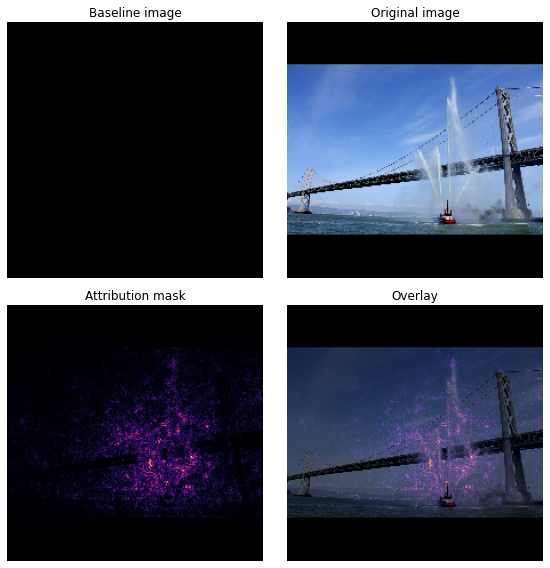

In [ ]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

在“大熊猫”图像上，归因突出显示了熊猫面部的纹理、鼻子和皮毛。

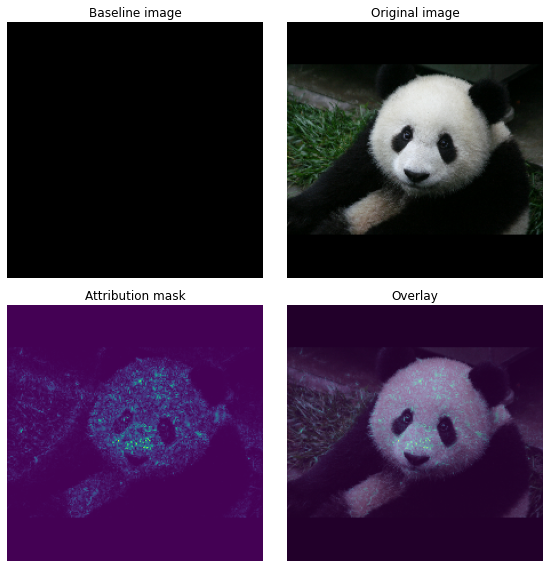

In [ ]:
_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=389,
                          m_steps=55,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)

## 用例和局限性

用例

- 在部署模型之前采用积分梯度之类的技术可以帮助您培养了解其工作原理的直觉。这项技术突出显示的特征是否符合您的直觉？如果不符合，则可能表明存在过拟合或者您的模型或数据集中存在错误。

局限性

- 积分梯度提供了单个样本的特征重要性，但是，它未提供整个数据集的全局特征重要性。

- 积分梯度提供了各个特征的重要性，但并未解释特征的相互作用和组合。

## 后续步骤

本教程介绍了积分梯度的基本实现。接下来，您可以利用此笔记本自行尝试在不同模型和图像上使用此技术。

对于感兴趣的读者，可以在[此处](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/blogs/integrated_gradients)找到本教程的加长版本（包括用于不同基线、计算积分逼近以及确定足够步数的代码）。

为了加深您的理解，请参阅论文 [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365) 和 [Github 仓库](https://github.com/ankurtaly/Integrated-Gradients)，其中包含 TensorFlow 先前版本中的实现。您也可以探索特征归因以及不同基线对 [distill.pub](https://distill.pub/2020/attribution-baselines/) 的影响。

有兴趣将 IG 融合到您的生产机器学习工作流中来实现特征重要性、模型错误分析和数据倾斜监控吗？查看 Google Cloud 支持 IG 归因的[可解释人工智能](https://cloud.google.com/explainable-ai)产品。Google AI PAIR 研究小组还将 [What-if 工具](https://pair-code.github.io/what-if-tool/index.html#about)开源，此工具可用于包括可视化 IG 特征归因在内的模型调试。